# 1. 데이터 준비와 전처리
- MovieLens 1M dataset 사용.
- 별점 데이터는 대표적인 명시적 데이터나 여기서는 암묵적 데이터로 간주.
- 별점 데이터는 시청횟수로 간주.
- 별점 3점 미만 데이터는 미선호로 가정하고 제외함.

In [1]:
import time
start_time = time.time()

import pandas as pd
import os

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
import numpy as np

In [2]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
raw_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'raw_data_size: {raw_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / raw_data_size:.2%}')

raw_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [5]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [6]:
#ratings = ratings['user_id', 'movie_id', 'counts']
using_cols = ['user_id', 'movie_id', 'counts']
ratings = ratings[using_cols]
ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')

movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [9]:
data = ratings.copy()
data.insert(2, 'title', ratings['movie_id'].map(movies.set_index('movie_id')['title']))

data

,user_id,movie_id,title,counts
0,1,1193,One Flew Over the Cuckoo's Nest (1975),5
1,1,661,James and the Giant Peach (1996),3
2,1,914,My Fair Lady (1964),3
3,1,3408,Erin Brockovich (2000),4
4,1,2355,"Bug's Life, A (1998)",5
...,...,...,...,...
1000203,6040,1090,Platoon (1986),3
1000205,6040,1094,"Crying Game, The (1992)",5
1000206,6040,562,Welcome to the Dollhouse (1995),5
1000207,6040,1096,Sophie's Choice (1982),4


In [10]:
# MF 모델 구성

# 2. 분석하기
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [11]:
# 분석 코드
print('총 영화 타이틀 수:',ratings['movie_id'].nunique())
print('총 사용자 수:',ratings['user_id'].nunique())

총 영화 타이틀 수: 3628
총 사용자 수: 6039


In [12]:
movie_count = data['title'].value_counts()
print('가장 인기있는 영화 30개')
movie_count.head(30)

가장 인기있는 영화 30개


American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Princess

In [13]:
# 유저별 몇 편의 영화를 봤는지에 대한 통계
user_count = data.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [14]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['movie_id'].median()
user_median.describe()

count    6039.000000
mean     1804.344428
std       518.591190
min       566.000000
25%      1391.000000
50%      1684.000000
75%      2014.500000
max      3919.500000
Name: movie_id, dtype: float64

# 3. 선호 영화 5가지 골라 ratings에 추가하기
## (1) 모델 검증을 위한 사용자 초기 정보 세팅

In [15]:
# 선호 영화 추가 코드

favorite_movie_5 = ['Tango (1998)', 'Good Will Hunting (1997)', 'Home Alone (1990)', 'Matrix, The (1999)', 'Jumanji (1995)']

my_playlist = pd.DataFrame({'user_id': ['cham']*5, 'title': favorite_movie_5, 'counts':[5]*5})

if not data.isin({'user_id':['cham']})['user_id'].any():  
    data = data.append(my_playlist)

data.drop(['movie_id'], axis=1, inplace=True) 
data.tail(10)

,user_id,title,counts
1000203,6040,Platoon (1986),3
1000205,6040,"Crying Game, The (1992)",5
1000206,6040,Welcome to the Dollhouse (1995),5
1000207,6040,Sophie's Choice (1982),4
1000208,6040,E.T. the Extra-Terrestrial (1982),4
0,cham,Tango (1998),5
1,cham,Good Will Hunting (1997),5
2,cham,Home Alone (1990),5
3,cham,"Matrix, The (1999)",5
4,cham,Jumanji (1995),5


## (2) 모델에 활용하기 위한 전처리

In [16]:
# 고유한 유저, 영화를 찾아내는 코드 
user_unique = data['user_id'].unique() 
movie_unique = data['title'].unique() 

# 유저, 영화 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)} 
title_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [17]:
# 인덱싱 검증
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   
else:
    print('user_id column indexing Fail!!')

temp_title_data = data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

data

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,937,5
1,6039,248,5
2,6039,507,5
3,6039,124,5


# 4. CSR matrix

In [18]:
# CSR matrix code
num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()
print(num_user)
print(num_movie)

6040
3628


In [19]:
csr_data = csr_matrix((data.counts, (data.user_id, data.title)), shape = (num_user, num_movie))
print(csr_data)

  (0, 0)	5
  (0, 1)	3
  (0, 2)	3
  (0, 3)	4
  (0, 4)	5
  (0, 5)	3
  (0, 6)	5
  (0, 7)	5
  (0, 8)	4
  (0, 9)	4
  (0, 10)	5
  (0, 11)	4
  (0, 12)	4
  (0, 13)	4
  (0, 14)	5
  (0, 15)	4
  (0, 16)	3
  (0, 17)	4
  (0, 18)	5
  (0, 19)	4
  (0, 20)	3
  (0, 21)	3
  (0, 22)	5
  (0, 23)	5
  (0, 24)	3
  :	:
  (6038, 2311)	4
  (6038, 2317)	5
  (6038, 2386)	4
  (6038, 2394)	5
  (6038, 2424)	4
  (6038, 2437)	4
  (6038, 2446)	5
  (6038, 2471)	4
  (6038, 2511)	5
  (6038, 2523)	4
  (6038, 2559)	3
  (6038, 2560)	4
  (6038, 2631)	5
  (6038, 2648)	4
  (6038, 2654)	5
  (6038, 2738)	4
  (6038, 2740)	5
  (6038, 2857)	5
  (6038, 2860)	3
  (6038, 3311)	5
  (6039, 124)	5
  (6039, 248)	5
  (6039, 507)	5
  (6039, 513)	5
  (6039, 937)	5


# 5. als model 구성 및 훈련

In [20]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [21]:
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 6. 내가 선호하는 5가지 영화중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도 파악

In [22]:
# 사용자 선호도 벡터
cham, jumanji = user_to_idx['cham'], title_to_idx['Jumanji (1995)']
cham_vector, jumanji_vector = als_model.user_factors[cham], als_model.item_factors[jumanji]
cham_vector

array([-0.23589721, -0.26120222,  0.30205816,  0.47581738,  0.16862015,
        0.12883769,  0.43733954, -0.44208598, -0.461442  ,  0.06254496,
       -0.15806663,  0.3044138 ,  0.39007238, -0.2552041 , -0.7629987 ,
        0.4180928 ,  0.37064707, -0.28796485, -0.9756834 , -0.01924607,
        0.7067541 ,  0.16212377,  0.5411363 , -0.40652546,  0.28420734,
        0.17647994, -0.44752505, -0.69529396, -0.3594494 , -0.44725934,
        0.61785674,  0.0819581 ,  0.28085047,  0.32655814, -0.49626583,
        0.0862812 , -0.50536615, -0.25657278, -0.4153747 ,  0.17315485,
        0.5871889 ,  0.80176806, -0.69704884, -0.05851692,  0.42328906,
       -0.43903598,  0.56612206, -0.3631333 , -0.10033464,  0.13554648,
       -0.45985585,  0.11298359,  0.5129095 , -0.00278495, -0.05576288,
        0.20162548, -0.2609468 ,  0.7476975 ,  0.03308636,  0.06157076,
        0.14489993,  0.06479272, -0.8786754 , -0.50461507,  0.5239749 ,
        0.35347664,  0.27675936,  0.09986749, -0.49793667,  0.87

In [23]:
# 타이틀 유사도 벡터
jumanji_vector

array([ 5.58631076e-03,  1.19877756e-02,  2.12925076e-02,  5.11372462e-03,
        1.08546168e-02,  2.44408790e-02,  1.15469266e-02,  8.84337630e-03,
       -4.13841149e-03,  5.98588726e-03, -1.02014723e-03, -1.34865067e-03,
        2.61011850e-02, -4.48274240e-03, -1.19495019e-02, -3.32202041e-03,
        9.83882695e-03,  2.95102037e-02,  3.33784823e-03,  2.20184289e-02,
       -1.27146933e-02, -4.04734118e-03,  2.17396691e-02, -1.58646535e-02,
        3.46999839e-02,  7.66368257e-03, -2.34062579e-02, -4.42991499e-03,
        1.85539236e-03,  1.15045635e-02,  2.05624360e-03,  3.85687308e-04,
        3.48347658e-03,  2.42441595e-02, -1.05419038e-02,  1.90654509e-02,
       -2.44048536e-02, -2.62008104e-02,  4.00908152e-03,  1.71027742e-02,
        3.22414301e-02,  1.56888347e-02, -3.15425801e-03,  7.02012284e-03,
        3.35328579e-02,  1.77034494e-02, -1.43092813e-03,  1.80431753e-02,
        2.31184438e-02,  1.49628380e-02, -1.84402075e-02, -5.35581447e-03,
        1.26371905e-02, -

In [24]:
# 사용자와 선호 타이틀의 취향 일치도
np.dot(cham_vector, jumanji_vector)

0.2692352

In [25]:
# 사용자와 임의 타이틀의 취향 일치도
babe = title_to_idx['Babe (1995)']
babe_vector = als_model.item_factors[babe]
np.dot(cham_vector, babe_vector)

0.07596613

# 7. 내가 좋아하는 영화와 비슷한 영화 추천받기
### 1번째 선호 타이틀의 유사도 확인

In [26]:
# 타이틀 유사도 확인
favorite_title = 'Tango (1998)'
title_id_1 = title_to_idx[favorite_title]
similar_title_1 = als_model.similar_items(title_id_1, N=10)
similar_title_1

[(937, 1.0),
 (2260, 0.795101),
 (2874, 0.77192736),
 (2578, 0.7642351),
 (2582, 0.7589609),
 (2576, 0.74494004),
 (2129, 0.7437893),
 (2246, 0.73765814),
 (2634, 0.7376347),
 (2593, 0.7340109)]

In [27]:
# 유사도 10순위에 해당되는 영화 제목 출력. 
idx_to_title = {v:k for k,v in title_to_idx.items()}
similar_movies_1 = pd.DataFrame([idx_to_title[i[0]] for i in similar_title_1])
similar_movies_1.rename(columns = {0 : 'title'}, inplace = True)
similar_movies_1.insert(1, 'genre', similar_movies_1['title'].map(movies.set_index('title')['genre']))
similar_movies_1

,title,genre
0,Tango (1998),Drama
1,Nelly & Monsieur Arnaud (1995),Drama
2,Déjà Vu (1997),Drama|Romance
3,Three Seasons (1999),Drama
4,"Harmonists, The (1997)",Drama
5,"Winter Guest, The (1997)",Drama
6,Character (Karakter) (1997),Drama
7,"Golden Bowl, The (2000)",Drama
8,Live Flesh (1997),Drama
9,My Favorite Season (1993),Drama


### 2번째 선호 타이틀의 유사도 확인

In [28]:
favorite_title = 'Good Will Hunting (1997)'
title_id_2 = title_to_idx[favorite_title]
similar_title_2 = als_model.similar_items(title_id_2, N=10)
similar_title_2

[(248, 0.99999994),
 (157, 0.64714193),
 (39, 0.6420986),
 (385, 0.63280284),
 (18, 0.53601223),
 (222, 0.51274544),
 (323, 0.5119472),
 (483, 0.49523044),
 (23, 0.49414033),
 (384, 0.49271774)]

In [29]:
similar_movies_2 = pd.DataFrame([idx_to_title[i[0]] for i in similar_title_2])
similar_movies_2.rename(columns = {0 : 'title'}, inplace = True)
similar_movies_2.insert(1, 'genre', similar_movies_2['title'].map(movies.set_index('title')['genre']))
similar_movies_2

,title,genre
0,Good Will Hunting (1997),Drama
1,"Shawshank Redemption, The (1994)",Drama
2,Apollo 13 (1995),Drama
3,"Truman Show, The (1998)",Drama
4,Awakenings (1990),Drama
5,Pulp Fiction (1994),Crime|Drama
6,Dead Man Walking (1995),Drama
7,Trainspotting (1996),Drama
8,Schindler's List (1993),Drama|War
9,Jerry Maguire (1996),Drama|Romance


### 3번째 선호 타이틀의 유사도 확인

In [30]:
favorite_title = 'Home Alone (1990)'
title_id_3 = title_to_idx[favorite_title]
similar_title_3 = als_model.similar_items(title_id_3, N=10)
similar_title_3

[(507, 0.9999999),
 (821, 0.67864877),
 (668, 0.6743748),
 (341, 0.65164435),
 (2015, 0.6429204),
 (1180, 0.6349888),
 (1369, 0.6264711),
 (567, 0.60701233),
 (244, 0.60429615),
 (931, 0.5953249)]

In [31]:
similar_movies_3 = pd.DataFrame([idx_to_title[i[0]] for i in similar_title_3])
similar_movies_3.rename(columns = {0 : 'title'}, inplace = True)
similar_movies_3.insert(1, 'genre', similar_movies_3['title'].map(movies.set_index('title')['genre']))
similar_movies_3

,title,genre
0,Home Alone (1990),Children's|Comedy
1,Mrs. Doubtfire (1993),Comedy
2,Sister Act (1992),Comedy|Crime
3,"Mighty Ducks, The (1992)",Children's|Comedy
4,Home Alone 2: Lost in New York (1992),Children's|Comedy
5,Father of the Bride Part II (1995),Comedy
6,101 Dalmatians (1996),Children's|Comedy
7,"First Wives Club, The (1996)",Comedy
8,Liar Liar (1997),Comedy
9,Hocus Pocus (1993),Children's|Comedy


### 4번째 선호 타이틀의 유사도 확인

In [32]:
favorite_title = 'Matrix, The (1999)'
title_id_4 = title_to_idx[favorite_title]
similar_title_4 = als_model.similar_items(title_id_4, N=10)
similar_title_4

[(124, 1.0000001),
 (92, 0.77951133),
 (62, 0.6546159),
 (141, 0.57725334),
 (107, 0.5666393),
 (200, 0.56316996),
 (145, 0.5411349),
 (375, 0.5119482),
 (175, 0.47370568),
 (75, 0.4214954)]

In [33]:
similar_movies_4 = pd.DataFrame([idx_to_title[i[0]] for i in similar_title_4])
similar_movies_4.rename(columns = {0 : 'title'}, inplace = True)
similar_movies_4.insert(1, 'genre', similar_movies_4['title'].map(movies.set_index('title')['genre']))
similar_movies_4

,title,genre
0,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller
3,"Fugitive, The (1993)",Action|Thriller
4,Jurassic Park (1993),Action|Adventure|Sci-Fi
5,"Terminator, The (1984)",Action|Sci-Fi|Thriller
6,"Fifth Element, The (1997)",Action|Sci-Fi
7,Face/Off (1997),Action|Sci-Fi|Thriller
8,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
9,"Hunt for Red October, The (1990)",Action|Thriller


### 5번째 선호 타이틀의 유사도 확인

In [34]:
favorite_title = 'Jumanji (1995)'
title_id_5 = title_to_idx[favorite_title]
similar_title_5 = als_model.similar_items(title_id_5, N=10)
similar_title_5

[(513, 1.0000001),
 (596, 0.81434697),
 (1130, 0.7969768),
 (173, 0.73342097),
 (545, 0.6695829),
 (828, 0.65612125),
 (1985, 0.6540115),
 (1982, 0.6383163),
 (1736, 0.63013387),
 (1733, 0.62990075)]

In [35]:
similar_movies_5 = pd.DataFrame([idx_to_title[i[0]] for i in similar_title_5])
similar_movies_5.rename(columns = {0 : 'title'}, inplace = True)
similar_movies_5.insert(1, 'genre', similar_movies_5['title'].map(movies.set_index('title')['genre']))
similar_movies_5

,title,genre
0,Jumanji (1995),Adventure|Children's|Fantasy
1,Hook (1991),Adventure|Fantasy
2,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
3,Dragonheart (1996),Action|Adventure|Fantasy
4,"Santa Clause, The (1994)",Children's|Comedy|Fantasy
5,Flubber (1997),Children's|Comedy|Fantasy
6,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children's|Fantasy
7,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy
8,Small Soldiers (1998),Animation|Children's|Fantasy|War
9,"Borrowers, The (1997)",Adventure|Children's|Comedy|Fantasy


## (2) 타이틀 변경 및 장르 확인

# 8. 내가 가장 좋아할만한 영화들 추천받기

In [36]:
user = user_to_idx['cham']
title_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
title_recommended

[(92, 0.31178278),
 (107, 0.28137928),
 (317, 0.25068718),
 (141, 0.23063475),
 (62, 0.22193347),
 (458, 0.21725665),
 (48, 0.21338992),
 (157, 0.21212271),
 (596, 0.21197152),
 (145, 0.20595935),
 (40, 0.20092769),
 (175, 0.19954756),
 (23, 0.18931514),
 (330, 0.18102568),
 (450, 0.1790201),
 (121, 0.17608255),
 (545, 0.17512654),
 (375, 0.17287052),
 (244, 0.16987938),
 (233, 0.16795139)]

In [37]:
recommended_movies = pd.DataFrame([idx_to_title[i[0]] for i in title_recommended])
recommended_movies.rename(columns = {0 : 'title'}, inplace = True)
recommended_movies.insert(1, 'genre', recommended_movies['title'].map(movies.set_index('title')['genre']))
recommended_movies

,title,genre
0,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
1,Jurassic Park (1993),Action|Adventure|Sci-Fi
2,Twelve Monkeys (1995),Drama|Sci-Fi
3,"Fugitive, The (1993)",Action|Thriller
4,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller
5,"Mask, The (1994)",Comedy|Crime|Fantasy
6,Saving Private Ryan (1998),Action|Drama|War
7,"Shawshank Redemption, The (1994)",Drama
8,Hook (1991),Adventure|Fantasy
9,"Fifth Element, The (1997)",Action|Sci-Fi


In [38]:
tango = title_to_idx['Tango (1998)']
explain = als_model.explain(user, csr_data, itemid=tango)
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Tango (1998)', 0.03661417466102963),
 ('Good Will Hunting (1997)', 0.008808886957461274),
 ('Home Alone (1990)', 0.0068944690380541105),
 ('Matrix, The (1999)', -0.0022028706039973647),
 ('Jumanji (1995)', -0.011071281691577372)]

In [39]:
end_time = time.time()
work_time = round(end_time - start_time)
print(f'총 작업 소요 시간은 약 {work_time}초입니다.')

총 작업 소요 시간은 약 23초입니다.


# Rubric
- 1. CSR matrix가 정상적으로 만들어졌다. -> 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.
- 2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다. -> 사용자와 아이템 벡터 내적 수치가 의미있게 형성되었다.
- 3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다. -> MF 모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.

# 회고
- 유사도 벡터는 자기 자신의 경우 1이었다. 그래서 혹시 similar_item() 함수는 정규화된 자기 자신의 전치행렬을 기준으로 하여 비교대상 행렬들을 정규화하고 곱한 것이 아닐까 생각하였다. 그래서 소스 코드를 찾아보았는데, 이해할 수 있을 정도로 의미있는 결과는 찾지 못하였다. 아래 첨부 이미지의 self.similarity가 그나마 근접한 것인데, 그 이후 소스 코드는 이해 불가. 많은 공부가 필요하다는 것을 다시 한 번 느꼈다.
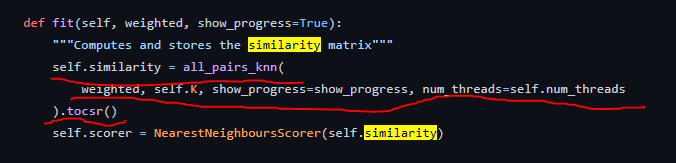
- 선호 영화에 따른 유사 영화 추천은 성공적이었던 것으로 보인다. 장르로 확인해 보았더니 각기 드라마, 드라마, 코메디, 스릴러, 판타지로 동일 혹은 유사 장르가 선순위로 추천되었다.
- 사용자에 대한 추천은 유사도 점수는 높지 않았다. 선호 영화에 여러 장르를 넣어 놓아서 그런 것으로 생각된다. 하지만 순위를 보고 주관적으로 판단했을 때, 납득할 수 있었다. 20개 순위 중 대부분을 보았기 때문이다. 결과적으로는 성공적으로 생각한다.